## Setup

### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt

### Load Saved Experiments

In [4]:
# TODO load experiments from disk and warn if not found
experiment_file_names = [
    'experiment_RoBERTa-Base (Baseline).pt',
    'experiment_RoBERTa-Base (AAN).pt',
    'experiment_DynaSent-M1 (Baseline).pt',
    'experiment_DynaSent-M1 (AAN).pt',
]

device = 'cpu'


def phi(text):
    return text
    
experiments = []
for file_name in experiment_file_names:
    experiment = torch.load(os.path.join('models', file_name))
    experiments.append(experiment)
    experiment["model"].model = experiment["model"].model.to(device)
    print(f'Loaded experiment for model {experiment["model"]}')

Loaded experiment for model RoBERTa-Base (Baseline)
Loaded experiment for model RoBERTa-Base (AAN)
Loaded experiment for model DynaSent-M1 (Baseline)
Loaded experiment for model DynaSent-M1 (AAN)


## Experiment Evaluation

### Metrics over Training

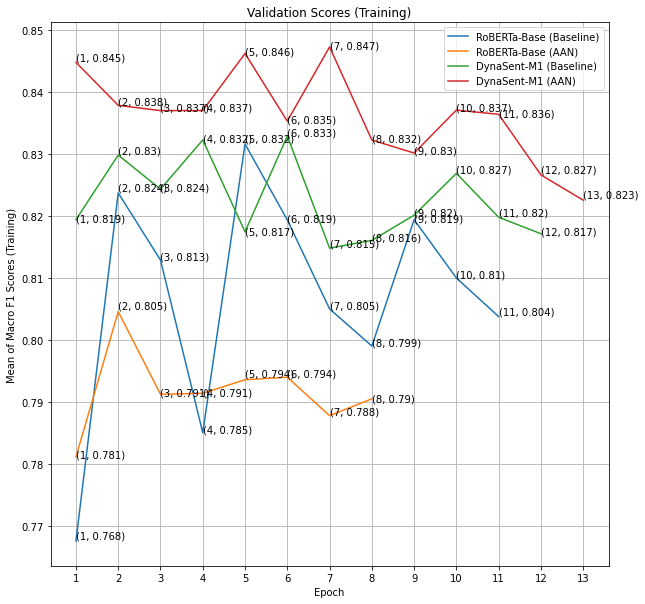

In [5]:


# Plot validation scores computed during training on held-out portions of the train set
def plot_scores():
    # TODO graph .validation_scores
    plt.rcParams["figure.figsize"] = 10, 10
    for experiment in experiments:
        scores = experiment['model'].validation_scores
        epochs = list(range(1, len(scores) + 1))
        plt.plot(epochs, scores, label=f'{experiment["model"]}')
        # Data labels
        rounded_scores = [round(score, 3) for score in scores]
        for xy in zip(epochs, rounded_scores):
            plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.ylabel('Mean of Macro F1 Scores (Training)')
    plt.xlabel('Epoch')
    plt.title('Validation Scores (Training)')
    plt.grid()
    plt.xticks(epochs)
    plt.legend()


    plt.show()

plot_scores()

## Error analysis

This section begins to build an error-analysis framework using the dicts returned by `sst.experiment`. These have the following structure:

```
'model': trained model
'phi': the feature function used
'train_dataset':
   'X': feature matrix
   'y': list of labels
   'vectorizer': DictVectorizer,
   'raw_examples': list of raw inputs, before featurizing   
'assess_datasets': list of datasets, each with the same structure as the value of 'train_dataset'
'predictions': list of lists of predictions on the assessment datasets
'metric': `score_func.__name__`, where `score_func` is an `sst.experiment` argument
'score': the `score_func` score on the each of the assessment dataasets
```
The following function just finds mistakes, and returns a `pd.DataFrame` for easy subsequent processing:

In [ ]:
def find_errors(experiment):
    """Find mistaken predictions.

    Parameters
    ----------
    experiment : dict
        As returned by `sst.experiment`.

    Returns
    -------
    pd.DataFrame

    """
    dfs = []
    for i, dataset in enumerate(experiment['assess_datasets']):
        df = pd.DataFrame({
            'raw_examples': dataset['raw_examples'],
            'predicted': experiment['predictions'][i],
            'gold': dataset['y']})
        df['correct'] = df['predicted'] == df['gold']
        df['dataset'] = i
        dfs.append(df)
    return pd.concat(dfs)

In [ ]:
rnn_analysis = find_errors(rnn_experiment)

Here we merge the sotmax and RNN experiments into a single DataFrame:

In [ ]:
analysis = softmax_analysis.merge(
    rnn_analysis, left_on='raw_examples', right_on='raw_examples')

analysis = analysis.drop('gold_y', axis=1).rename(columns={'gold_x': 'gold'})

The following code collects a specific subset of examples; small modifications to its structure will give you different interesting subsets:

In [ ]:
# Examples where the softmax model is correct, the RNN is not,
# and the gold label is 'positive'

error_group = analysis[
    (analysis['predicted_x'] == analysis['gold'])
    &
    (analysis['predicted_y'] != analysis['gold'])
    &
    (analysis['gold'] == 'positive')
]

error_group.shape[0]

for ex in error_group['raw_examples'].sample(5, random_state=1):
    print("="*70)
    print(ex)

In [ ]:
def predict_one_rnn(text):
    # List of tokenized examples:
    X = [rnn_experiment['phi'](text)]
    # Standard `predict` step on a list of lists of str:
    # TODO be sure to change the model to eval mode before predicting
    preds = rnn_experiment['model'].predict(X)
    # Be sure to return the only member of the predictions,
    # rather than the singleton list:
    return preds[0]